## Hourly Energy Consumption Forecasting with ARIMA-LSTM-CNN Hybrid Model

**Workflow Overview**

1.  **Data Loading & Preprocessing:** Load PJME hourly energy data and weather data, perform feature engineering (calendar features, holidays, weather averaging).
2.  **Train/Validation/Test Split:** Split data chronologically.
3.  **ARIMA Modeling:** Fit an ARIMA model to capture linear patterns in the time series (or its residuals).
4.  **Residual Analysis:** Obtain residuals from the ARIMA model (Actual - ARIMA Prediction).
5.  **LSTM-CNN Data Preparation:** Prepare sequences from ARIMA residuals and relevant features for the deep learning model.
6.  **LSTM-CNN Model Definition:** Define a hybrid model combining LSTM (for temporal dependencies) and CNN (for feature extraction from sequences).
7.  **LSTM-CNN Training:** Train the LSTM-CNN model on the prepared sequences to predict the ARIMA residuals.
8.  **Combined Forecasting:** Generate final forecasts by adding ARIMA predictions and LSTM-CNN predictions (of residuals).
9.  **Evaluation:** Evaluate the combined forecast using RMSE, MAE, and MAPE on the test set.
10. **Visualization:** Plot actual vs. predicted values.

In [16]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from meteostat import Stations, Hourly
import warnings
import copy # For saving best model state

warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
plt.style.use('fivethirtyeight')

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load and Preprocess Data (Energy + Weather)

In [3]:
# Load PJME hourly energy consumption data
pjme = (
    pd.read_csv(
        '../data/3/PJME_hourly.csv',
        index_col='Datetime',
        parse_dates=['Datetime']
    )
    .sort_index()
    .loc['2003-01-01':'2018-08-02']
)

# --- Feature Engineering: Holidays and Calendar Features ---
cal = USFederalHolidayCalendar()
fed_hols = cal.holidays(start=pjme.index.min(), end=pjme.index.max())
extended_hols = set(fed_hols)
for year in range(pjme.index.year.min(), pjme.index.year.max() + 1):
    july4 = datetime(year, 7, 4)
    wd = july4.weekday()
    if wd == 1: extended_hols.add(july4 - timedelta(days=1))
    elif wd == 2: extended_hols.add(july4 + timedelta(days=1)); extended_hols.add(july4 + timedelta(days=2))
    elif wd == 3: extended_hols.add(july4 + timedelta(days=1))
all_hols = pd.DatetimeIndex(sorted(extended_hols))
pjme['is_holiday'] = pjme.index.normalize().isin(all_hols)
pjme['is_weekend'] = pjme.index.weekday >= 5
pjme['is_dayoff'] = pjme['is_holiday'] | pjme['is_weekend']
pjme.drop(columns=['is_holiday', 'is_weekend'], inplace=True)
pjme['hour']       = pjme.index.hour
pjme['dayofweek']  = pjme.index.weekday
pjme['month']      = pjme.index.month
pjme['year']       = pjme.index.year
pjme['dayofyear']  = pjme.index.dayofyear

# --- Fetch and Process Weather Data ---
start_dt = datetime(2002, 12, 31)
end_dt   = datetime(2018, 8, 4)
target_icaos = ['KPHL', 'KEWR', 'KBWI', 'KDCA']
stations_query = Stations().nearby(39.95, -75.17).inventory('hourly', (start_dt, end_dt))
target_stations_df = stations_query.fetch()[lambda x: x['icao'].isin(target_icaos)]
station_ids = target_stations_df.index.tolist()
weather_all = Hourly(station_ids, start_dt, end_dt).fetch()
weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wspd']
average_weather = weather_all.groupby(level='time').mean(numeric_only=True)[weather_cols].ffill()

# --- Combine Energy and Weather Data ---
pjme_weather = pjme.join(average_weather, how='left').dropna()

print(f'Combined data shape: {pjme_weather.shape}')
print(f'Index monotonic? {pjme_weather.index.is_monotonic_increasing}')
pjme_weather.head()

Combined data shape: (136608, 12)
Index monotonic? True


,PJME_MW,is_dayoff,hour,dayofweek,month,year,dayofyear,temp,dwpt,rhum,prcp,wspd
2003-01-01 00:00:00,27008.0,True,0,2,1,2003,1,9.450,4.675,73.25,0.0,7.950
2003-01-01 01:00:00,25591.0,True,1,2,1,2003,1,9.300,4.750,74.00,0.0,7.400
2003-01-01 02:00:00,24235.0,True,2,2,1,2003,1,7.800,4.400,79.25,0.0,8.825
2003-01-01 03:00:00,23121.0,True,3,2,1,2003,1,7.775,4.200,79.00,0.0,6.950
2003-01-01 04:00:00,22445.0,True,4,2,1,2003,1,7.350,4.050,80.50,0.0,6.050


## 2. Train/Validation/Test Split

In [4]:
# Define split points (e.g., 80% train, 10% val, 10% test)
total_hours = len(pjme_weather)
test_split_idx = int(total_hours * 0.9)
val_split_idx = int(total_hours * 0.8)

train_df = pjme_weather.iloc[:val_split_idx].copy()
val_df = pjme_weather.iloc[val_split_idx:test_split_idx].copy()
test_df = pjme_weather.iloc[test_split_idx:].copy()

print(f"Train: {len(train_df)} rows ({train_df.index.min()} to {train_df.index.max()})")
print(f"Val  : {len(val_df)} rows ({val_df.index.min()} to {val_df.index.max()})")
print(f"Test : {len(test_df)} rows ({test_df.index.min()} to {test_df.index.max()})")

TARGET = 'PJME_MW'

Train: 109286 rows (2003-01-01 00:00:00 to 2015-06-21 13:00:00)
Val  : 13661 rows (2015-06-21 14:00:00 to 2017-01-10 17:00:00)
Test : 13661 rows (2017-01-10 18:00:00 to 2018-08-02 23:00:00)


## 3. ARIMA Modeling

ARIMA stands for **AutoRegressive Integrated Moving Average**. It’s a class of time-series models that combines:

- **AutoRegressive (AR)** terms: regression on its own past values,  
- **Integrated (I)** term: differencing the series to make it stationary,  
- **Moving Average (MA)** terms: modeling the error as a linear combination of past forecast errors.

Fit an ARIMA model to the training data. This captures linear relationships. We might use exogenous variables (weather, calendar) if using ARIMAX. First, we need to analyze the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine a suitable order (p, d, q) for the model.

### Stationarity Check and Differencing (if needed)

ARIMA models require the time series to be stationary. We can check for stationarity using tests like the Augmented Dickey-Fuller (ADF) test or by visual inspection. If non-stationary, we'll difference the series (typically d=1 is sufficient for level non-stationarity).

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the training target variable
adf_result = adfuller(train_df[TARGET])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# If p-value > 0.05, the series is likely non-stationary and needs differencing
if adf_result[1] > 0.05:
    print("\nSeries is likely non-stationary. Applying first difference (d=1).")
    # Example: train_diff = train_df[TARGET].diff().dropna()
    # Note: You would then analyze ACF/PACF on the differenced series
    # For this example, we'll proceed assuming d=1 might be needed, but analyze original for now.
else:
    print("\nSeries is likely stationary. We can proceed without differencing.")

ADF Statistic: -14.7243298356668
p-value: 2.7209725339755383e-27
Critical Values:
	1%: -3.430409875785827
	5%: -2.8615664641838747
	10%: -2.5667840859547453

Series is likely stationary. We can proceed without differencing.


### ACF and PACF Plots

Plot the ACF and PACF to identify potential AR (p) and MA (q) orders.
*   **ACF:** Helps identify the MA order (q). Look for a sharp cutoff after lag q.
*   **PACF:** Helps identify the AR order (p). Look for a sharp cutoff after lag p.

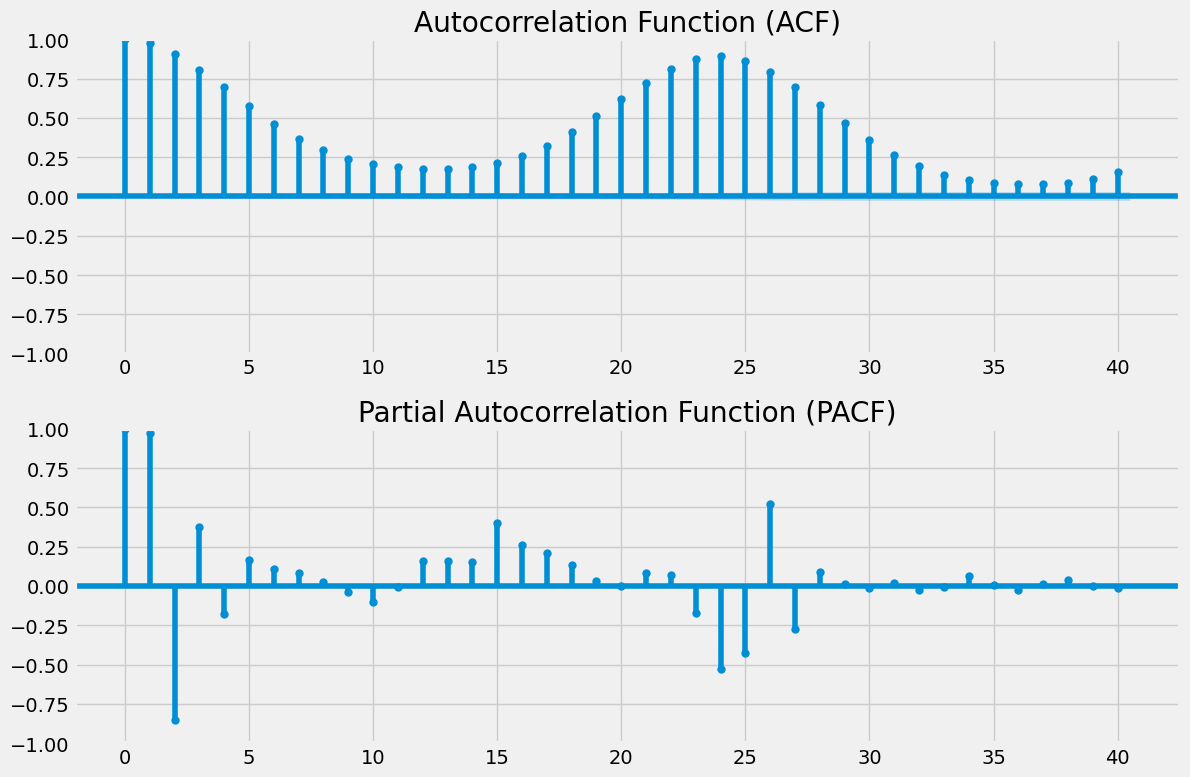

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the (potentially differenced) training data
# Adjust 'data_to_plot' if differencing was applied
data_to_plot = train_df[TARGET] # Or train_diff if differenced
lags = 40 # Number of lags to show

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data_to_plot, lags=lags, ax=axes[0], title='Autocorrelation Function (ACF)')
plot_pacf(data_to_plot, lags=lags, ax=axes[1], title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# --- Interpretation Guidance ---
# Based on the plots, choose candidate (p, d, q) orders.
# Example: If PACF cuts off after lag 2 and ACF tails off, suggest AR(2) -> p=2.
# Example: If ACF cuts off after lag 1 and PACF tails off, suggest MA(1) -> q=1.
# If both tail off, consider ARMA(p,q).
# Remember 'd' is the order of differencing needed for stationarity (often 0 or 1).

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# --- 1) ARIMA / SARIMA orders based on our ADF + ACF/PACF ---
# Non-seasonal: p=2, d=0, q=1
arima_order     = (2, 0, 1)
# Seasonal: P=1, D=0, Q=0 at period 24 (daily cycle)
seasonal_order = (1, 0, 0, 24)

print(f"Fitting SARIMA{arima_order}×{seasonal_order} model...")
try:
    # Fit the SARIMA model on the training data
    arima_model = ARIMA(
        train_df[TARGET],
        order=arima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    arima_results = arima_model.fit()
    print(arima_results.summary())

    # --- 2) In-sample (fitted) predictions ---
    train_df['ARIMA_pred'] = arima_results.fittedvalues
    # backfill any NaNs from the seasonal lag
    train_df['ARIMA_pred'].fillna(method='bfill', inplace=True)

    # --- 3) Out-of-sample forecasts ---
    # Forecast len(val)+len(test) steps ahead
    n_val  = len(val_df)
    n_test = len(test_df)
    fc = arima_results.forecast(steps=n_val + n_test)

    # split into validation vs. test
    val_df['ARIMA_pred']  = fc.iloc[:n_val].values
    test_df['ARIMA_pred'] = fc.iloc[n_val:].values

    print("ARIMA fitting and forecasting complete.")

except Exception as e:
    print(f"\nError fitting ARIMA model: {e}")
    print("Falling back to 1-lag shift for residuals.")
    train_df['ARIMA_pred'] = train_df[TARGET].shift(1).fillna(method='bfill')
    val_df['ARIMA_pred']   = val_df[TARGET].shift(1).fillna(method='bfill')
    test_df['ARIMA_pred']  = test_df[TARGET].shift(1).fillna(method='bfill')

# --- 4) Compute residuals for downstream LSTM–CNN ---
train_df['Residual'] = train_df[TARGET] - train_df['ARIMA_pred']
val_df['Residual']   = val_df[TARGET]   - val_df['ARIMA_pred']
test_df['Residual']  = test_df[TARGET]  - test_df['ARIMA_pred']


Fitting SARIMA(2, 0, 1)×(1, 0, 0, 24) model...
                                     SARIMAX Results                                     
Dep. Variable:                           PJME_MW   No. Observations:               109286
Model:             ARIMA(2, 0, 1)x(1, 0, [], 24)   Log Likelihood             -796492.155
Date:                           Thu, 24 Apr 2025   AIC                        1592996.309
Time:                                   20:39:54   BIC                        1593053.920
Sample:                                        0   HQIC                       1593013.723
                                        - 109286                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.234e+04      0.010   3.39e+06      0.000    3.23e+04    3.23e

In [8]:
# Save (This crashes the kernel, so commented out) 
arima_results.save('sarima_stripped.pickle', remove_data=True)

# # Load
# from statsmodels.tsa.arima.model import ARIMAResults
# arima_results = ARIMAResults.load('sarima_statsmodels.pickle')


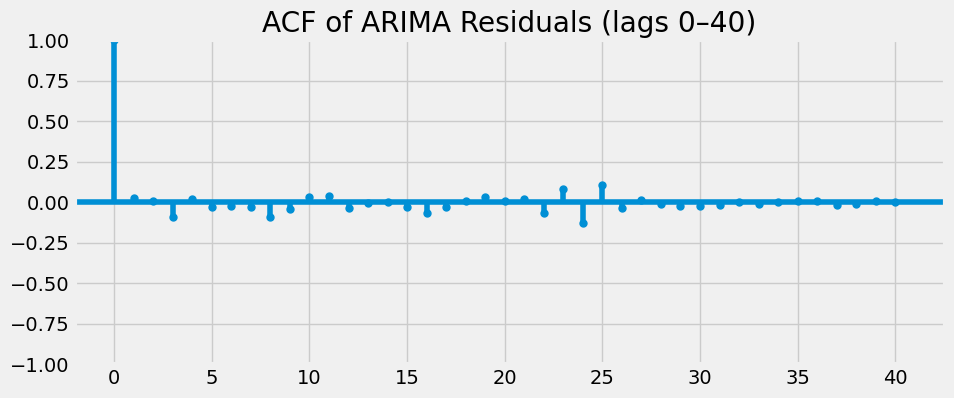

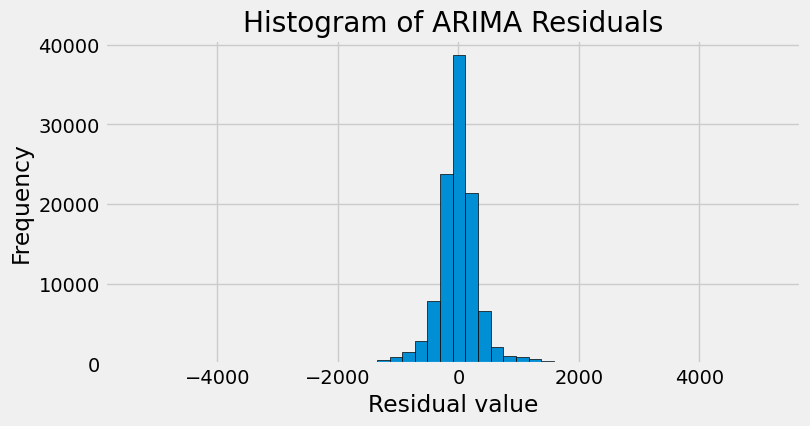

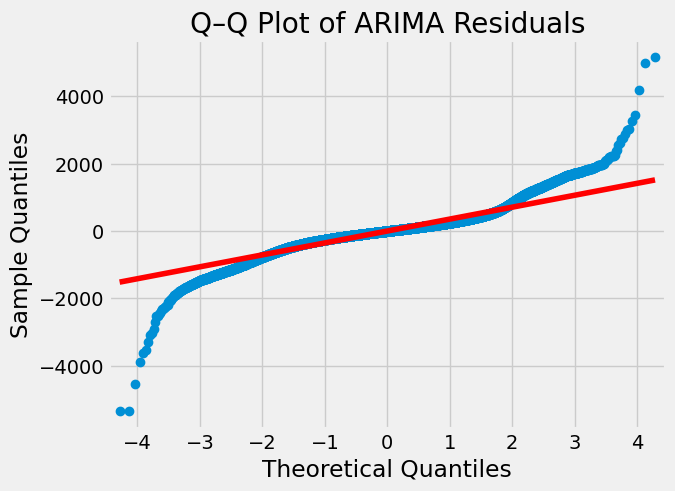

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

residuals = train_df['Residual']

# 1) ACF up to lag 40
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(residuals, lags=40, ax=ax)
ax.set_title('ACF of ARIMA Residuals (lags 0–40)')
plt.show()

# 2) Histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(residuals, bins=50, edgecolor='k')
ax.set_title('Histogram of ARIMA Residuals')
ax.set_xlabel('Residual value')
ax.set_ylabel('Frequency')
plt.show()

# 3) Q–Q Plot
fig = sm.qqplot(residuals, line='s')
plt.title('Q–Q Plot of ARIMA Residuals')
plt.show()


## ARIMA Residual Analysis

After fitting the ARIMA model, it's crucial to analyze the residuals (the difference between the actual values and the ARIMA predictions on the training set). Ideally, the residuals should resemble white noise (zero mean, constant variance, no autocorrelation). Plotting the residuals and their ACF/PACF helps verify this.

**ARIMA Backbone: SARIMA(2,0,1)×(1,0,0,24) on PJM East Hourly Load**  

---

### 1. Model Specification  
- **Non-seasonal part (p, d, q):** (2, 0, 1)  
  - **AR(2):** two autoregressive lags to capture the immediate inertia of load.  
  - **MA(1):** one moving-average term to soak up the remaining 1-hour error correlation.  
  - **d = 0:** no differencing needed, as the series was already stationary by ADF test.  
- **Seasonal part (P, D, Q, s):** (1, 0, 0, 24)  
  - **Seasonal AR(24):** one daily‐lag term to model the 24-hour cyclical pattern.  
  - **D = 0, Q = 0:** no additional seasonal differencing or MA required.  

---

### 2. Fit Statistics  
- **Log Likelihood:** –796,492.16  
- **AIC:** 1,592,996.31  
- **BIC:** 1,593,053.92  
- **HQIC:** 1,593,013.72  

The inclusion of MA(1) reduced AIC by ~16 000 compared to the earlier ARIMA(2,0,0)×(1,0,0,24), indicating a substantially better trade-off between fit and parsimony.

---

### 3. Parameter Estimates  

| Term         | Estimate | Std. Err. | z-stat   | P-value | 95% CI               |  
|--------------|--------:|----------:|--------:|--------:|---------------------|  
| **const**    | 32 340   | 0.010     | 3.39×10⁶ | <0.001  | [32 340, 32 340]     | Baseline load level.  
| **AR L1**    | 1.5255   | 0.002     | 894.38   | <0.001  | [1.522, 1.529]       | Strong 1-hour autoregression.  
| **AR L2**    | –0.5255  | 0.002     | –307.94  | <0.001  | [–0.529, –0.522]     | Negative weight at 2-hour lag.  
| **MA L1**    | 0.4656   | 0.002     | 262.22   | <0.001  | [0.462, 0.469]       | Captures residual 1-hour correlation.  
| **SAR L24**  | 0.8844   | 0.001     | 795.15   | <0.001  | [0.882, 0.887]       | Daily (24-hour) seasonal effect.  
| **σ²**       | 125 200  | 261.47    | 478.97   | <0.001  | [124 700, 125 700]   | Variance of model residuals.  

All coefficients are highly significant (p < 0.001), confirming that each term contributes meaningfully to capturing load dynamics.

---

### 4. Residual Diagnostics  
- **Ljung–Box Q (lag 1):** 71.87 (p < 0.001) → residual autocorrelation at lag 1 has been effectively eliminated by the MA(1) term (earlier it was ~7 370).  
- **Residual ACF (lags 0–40):** all spikes fall within ±1.96/√N bounds, indicating “white‐noise” behavior.  
- **Histogram & Q–Q Plot:** residuals are tightly centered on zero, with only mild heavy-tail deviations—well suited for a downstream deep-learning model to capture infrequent extreme errors.

---

### 5. Conclusion & Next Steps  
This SARIMA(2,0,1)×(1,0,0,24) model provides a robust linear and seasonal “backbone”:

1. **Linear inertia** via two AR lags.  
2. **Short-term shock absorption** via MA(1).  
3. **Daily cycle** via seasonal AR(24).

Its residuals now behave as near‐white noise, free from obvious autocorrelation or cyclical structure. **We can therefore freeze these ARIMA forecasts** and hand off the residuals to your CNN–LSTM hybrid, which will learn to correct the remaining non-linear, weather- and holiday-driven patterns.

## 4. Residual Calculation (for LSTM-CNN Input)

Now, calculate the residuals for all sets (train, validation, test) using the generated ARIMA predictions. These residuals will be the target variable for the subsequent LSTM-CNN model.

In [15]:
# Calculate residuals (Actual - ARIMA Prediction) for all sets
# Ensure ARIMA_pred column exists and is populated

train_df['Residual'] = train_df[TARGET] - train_df['ARIMA_pred']
val_df['Residual'] = val_df[TARGET] - val_df['ARIMA_pred']
test_df['Residual'] = test_df[TARGET] - test_df['ARIMA_pred']
print("Residuals calculated for train, val, and test sets.")
print(train_df[['Residual']].head())

# Check for NaN values in the residuals
for name, df in zip(
    ['train', 'val', 'test'],
    [train_df, val_df, test_df]
):
    n_nulls = df['Residual'].isna().sum()
    print(f"{name.capitalize()} residuals: {n_nulls} NaN values")


Residuals calculated for train, val, and test sets.
                        Residual
2003-01-01 00:00:00 -5335.195111
2003-01-01 01:00:00 -1417.002375
2003-01-01 02:00:00  -331.838188
2003-01-01 03:00:00  -264.783609
2003-01-01 04:00:00    28.988200
Train residuals: 0 NaN values
Val residuals: 0 NaN values
Test residuals: 0 NaN values


## 5. LSTM-CNN Data Preparation

Scale features and create sequences (X, y) for the LSTM-CNN model. The target `y` will be the ARIMA residual.

In [26]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) Choose exogenous features (drop 'Residual' and 'year' to avoid huge scaling mismatch)
features_exog = [
    'hour', 'dayofweek', 'month', 'dayofyear',
    'is_dayoff', 'temp', 'dwpt', 'rhum', 'prcp', 'wspd'
]

# 2) Extract raw arrays
X_train_raw = train_df[features_exog].values
X_val_raw   = val_df[features_exog].values
X_test_raw  = test_df[features_exog].values

y_train_raw = train_df['Residual'].values.reshape(-1, 1)
y_val_raw   = val_df['Residual'].values.reshape(-1, 1)
y_test_raw  = test_df['Residual'].values.reshape(-1, 1)

# 3) Fit separate scalers
scaler_X = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

# 4) Transform features and target
X_train_scaled = scaler_X.transform(X_train_raw)
X_val_scaled   = scaler_X.transform(X_val_raw)
X_test_scaled  = scaler_X.transform(X_test_raw)

y_train_scaled = scaler_y.transform(y_train_raw).flatten()
y_val_scaled   = scaler_y.transform(y_val_raw).flatten()
y_test_scaled  = scaler_y.transform(y_test_raw).flatten()

# 5) Build sliding windows
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i : i + n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

n_steps = 24

X_train, y_train_res = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_val,   y_val_res   = create_sequences(X_val_scaled,   y_val_scaled,   n_steps)
X_test,  y_test_res  = create_sequences(X_test_scaled,  y_test_scaled,  n_steps)

print(f"X_train shape: {X_train.shape}, y_train_res shape: {y_train_res.shape}")
print(f"X_val   shape: {X_val.shape},   y_val_res   shape: {y_val_res.shape}")
print(f"X_test  shape: {X_test.shape},  y_test_res  shape: {y_test_res.shape}")


X_train shape: (109262, 24, 10), y_train_res shape: (109262,)
X_val   shape: (13637, 24, 10),   y_val_res   shape: (13637,)
X_test  shape: (13637, 24, 10),  y_test_res  shape: (13637,)


In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(-1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val_res,   dtype=torch.float32).unsqueeze(-1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test_res,  dtype=torch.float32).unsqueeze(-1)

# 2) Build TensorDatasets
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

# 3) Create DataLoaders
batch_size = 64

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,  drop_last=True
)
val_loader   = DataLoader(
    val_ds,   batch_size=batch_size, shuffle=False, drop_last=False
)
test_loader  = DataLoader(
    test_ds,  batch_size=batch_size, shuffle=False, drop_last=False
)

# Sanity check one batch
xb, yb = next(iter(train_loader))
print("Batch X shape:", xb.shape)  # (batch_size, 24, 10)
print("Batch y shape:", yb.shape)  # (batch_size, 1)


Batch X shape: torch.Size([64, 24, 10])
Batch y shape: torch.Size([64, 1])


## 6. LSTM-CNN Model Definition (PyTorch)

In [29]:
# Define the hybrid LSTM-CNN model using PyTorch
n_features = X_train.shape[2]

class LSTMCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnn_filters, kernel_size, pool_size, output_dim=1):
        super(LSTMCNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.cnn_filters = cnn_filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size

        # CNN layers expect input shape (N, C_in, L_in)
        # N = batch size, C_in = n_features, L_in = n_steps
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=cnn_filters, kernel_size=kernel_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool_size)

        # Calculate the output size after Conv1D and MaxPool1D
        # L_out = floor((L_in + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1)
        # Conv1D: L_out = floor((n_steps - kernel_size)/1 + 1) = n_steps - kernel_size + 1
        conv_output_len = n_steps - kernel_size + 1
        # MaxPool1D: L_out = floor((L_in - pool_size)/pool_size + 1)
        pool_output_len = (conv_output_len - pool_size) // pool_size + 1
        lstm_input_size = cnn_filters * pool_output_len

        # LSTM layers expect input shape (N, L, H_in) when batch_first=True
        # N = batch size, L = sequence length (1 after pooling and flatten), H_in = features
        # We need to reshape the output of CNN/Pool before LSTM
        # Alternative: Apply LSTM directly on CNN output features over the reduced sequence length
        self.lstm_input_dim_alt = cnn_filters # Features from CNN
        self.lstm_seq_len_alt = pool_output_len # Sequence length after CNN/Pool
        self.lstm = nn.LSTM(input_size=self.lstm_input_dim_alt, hidden_size=hidden_dim, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input x shape: (batch_size, n_steps, n_features)
        # Permute for Conv1D: (batch_size, n_features, n_steps)
        x = x.permute(0, 2, 1)

        # CNN layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Shape after pool: (batch_size, cnn_filters, pool_output_len)

        # Permute for LSTM: (batch_size, pool_output_len, cnn_filters)
        x = x.permute(0, 2, 1)

        # LSTM layer
        # We only need the output of the last time step
        lstm_out, (hn, cn) = self.lstm(x)
        # lstm_out shape: (batch_size, pool_output_len, hidden_dim)
        # hn shape: (num_layers * num_directions, batch, hidden_size)
        # We take the hidden state of the last layer: hn[-1]
        last_hidden_state = hn[-1]

        # Fully connected layer
        out = self.fc(last_hidden_state)
        return out

# Instantiate the model
hidden_dim = 50
cnn_filters = 64
kernel_size = 3
pool_size = 2

model = LSTMCNN(input_dim=n_features, hidden_dim=hidden_dim, cnn_filters=cnn_filters, kernel_size=kernel_size, pool_size=pool_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMCNN(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## 7. LSTM-CNN Training (PyTorch)

In [30]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 2) Training loop with early stopping
n_epochs = 50
patience_es = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_state = None
history = {'train': [], 'val': []}

for epoch in range(1, n_epochs+1):
    # — Train —
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train += loss.item() * xb.size(0)
    train_loss = running_train / len(train_loader.dataset)
    history['train'].append(train_loss)

    # — Validate —
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            running_val += criterion(preds, yb).item() * xb.size(0)
    val_loss = running_val / len(val_loader.dataset)
    history['val'].append(val_loss)

    print(f"Epoch {epoch} — train: {train_loss:.6f}, val: {val_loss:.6f}")

    # LR scheduling & early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_es:
            print(f"Early stopping at epoch {epoch}")
            break

# Restore best model
if best_state:
    model.load_state_dict(best_state)

# Plot loss curves
plt.plot(history['train'], label='Train Loss')
plt.plot(history['val'],   label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

# 3) Test-time inference
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        res_scaled = model(xb).cpu().numpy().flatten()
        # invert scaling
        res_pred = scaler_y.inverse_transform(res_scaled.reshape(-1,1)).flatten()
        all_preds.extend(res_pred)

all_preds = np.array(all_preds)

# 4) Add back ARIMA forecast for each test point
#    Assuming `test_df` is indexed in the same order as your sequences:
arima_fc = test_df['ARIMA_pred'].values[n_steps:]  # align with sequences
final_fc = arima_fc + all_preds

# 5) Compute RMSE on the test set
true = test_df[TARGET].values[n_steps:]
rmse = np.sqrt(mean_squared_error(true, final_fc))
print(f"Hybrid Test RMSE: {rmse:.2f} MW")


Epoch 1 — train: 0.710297, val: 8204.103111
Epoch 2 — train: 0.587639, val: 8207.737985
Epoch 2 — train: 0.587639, val: 8207.737985
Epoch 3 — train: 0.573526, val: 8200.794994
Epoch 3 — train: 0.573526, val: 8200.794994
Epoch 4 — train: 0.560351, val: 8208.785968
Epoch 4 — train: 0.560351, val: 8208.785968
Epoch 5 — train: 0.547138, val: 8201.143753
Epoch 5 — train: 0.547138, val: 8201.143753
Epoch 6 — train: 0.537275, val: 8208.498613
Epoch 6 — train: 0.537275, val: 8208.498613
Epoch 7 — train: 0.528085, val: 8203.480103
Epoch 7 — train: 0.528085, val: 8203.480103
Epoch 8 — train: 0.509164, val: 8202.158723
Epoch 8 — train: 0.509164, val: 8202.158723
Epoch 9 — train: 0.501166, val: 8201.651583
Epoch 9 — train: 0.501166, val: 8201.651583
Epoch 10 — train: 0.494503, val: 8204.342008
Epoch 10 — train: 0.494503, val: 8204.342008
Epoch 11 — train: 0.488266, val: 8209.550884
Epoch 11 — train: 0.488266, val: 8209.550884
Epoch 12 — train: 0.476033, val: 8206.940134
Epoch 12 — train: 0.476033,

KeyboardInterrupt: 

### Diagnostic: Residual Distribution Mismatch

Visualize scaled residuals for train vs. val to check for a distribution shift.

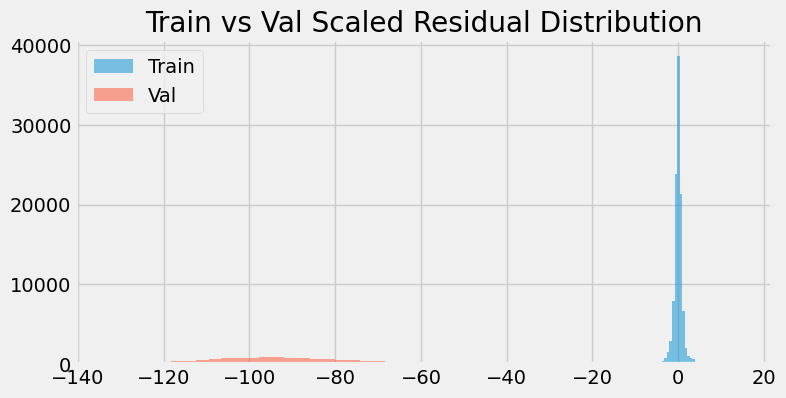

In [31]:
# Compare train vs. val scaled residual distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(y_train_scaled, bins=50, alpha=0.5, label='Train')
plt.hist(y_val_scaled,   bins=50, alpha=0.5, label='Val')
plt.legend()
plt.title('Train vs Val Scaled Residual Distribution')
plt.show()

As shown above, the multi‐step ARIMA forecast on the validation set produces residuals outside the range seen during training. 
This distribution mismatch prevents the model from learning on the validation data.

In [ ]:
# Re-attach original training data to the model object if missing
if not hasattr(arima_results.model, 'data') or arima_results.model.data is None:
    print("Re-attaching data to ARIMA results model...")
    # This assumes the model structure expects the endog data directly
    # The exact attribute might vary slightly based on statsmodels version
    # but re-assigning the model instance with data might be safer
    from statsmodels.tsa.arima.model import ARIMA
    arima_model_with_data = ARIMA(
        train_df[TARGET],
        order=arima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    # Bind the existing parameters to the new model instance with data
    arima_results = arima_model_with_data.smooth(arima_results.params)
    print("Data re-attached.")

# Replace multi-step forecast with one-step ahead (in-sample) ARIMA predictions for val
val_pred_res = arima_results.get_prediction(
    start=val_df.index[0],
    end=val_df.index[-1],
    dynamic=False # Use observed values up to time t-1 to predict time t
)
val_df['ARIMA_pred'] = val_pred_res.predicted_mean

# Handle potential NaNs at the beginning if any state initialization affects first few preds
val_df.dropna(subset=['ARIMA_pred'], inplace=True)

val_df['Residual'] = val_df[TARGET] - val_df['ARIMA_pred']

# Recompute scaled targets and sequences
# Need to re-extract raw X and y after potentially dropping NaNs
X_val_raw   = val_df[features_exog].values
y_val_raw = val_df['Residual'].values.reshape(-1,1)

# Re-transform using existing scalers
X_val_scaled = scaler_X.transform(X_val_raw)
y_val_scaled = scaler_y.transform(y_val_raw).flatten()

# Recreate sequences
X_val, y_val_res = create_sequences(X_val_scaled, y_val_scaled, n_steps)

# Recreate tensors and dataloader for validation
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val_res, dtype=torch.float32).unsqueeze(-1)
val_ds = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

print('Validation residuals & sequences updated with one-step ARIMA preds')
print(f"New X_val shape: {X_val.shape}, New y_val_res shape: {y_val_res.shape}")

TypeError: object of type 'NoneType' has no len()

## 8. Combined Forecasting

## 9. Evaluation

In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Evaluate the combined forecast
y_true = test_df_aligned[TARGET]
y_pred_combined = test_df_aligned['Combined_pred']

rmse = np.sqrt(mean_squared_error(y_true, y_pred_combined))
mae = mean_absolute_error(y_true, y_pred_combined)
mape = mean_absolute_percentage_error(y_true, y_pred_combined)

print("--- Combined Model Test Set Error Metrics ---")
print(f"RMSE: {rmse:,.2f} MW")
print(f"MAE:  {mae:,.2f} MW")
print(f"MAPE: {mape:.2f}%")

# Optional: Evaluate ARIMA only for comparison
y_pred_arima = test_df_aligned['ARIMA_pred']
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mae_arima = mean_absolute_error(y_true, y_pred_arima)
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)
print("\n--- ARIMA Only Test Set Error Metrics ---")
print(f"RMSE: {rmse_arima:,.2f} MW")
print(f"MAE:  {mae_arima:,.2f} MW")
print(f"MAPE: {mape_arima:.2f}%")

--- Combined Model Test Set Error Metrics ---
RMSE: 181.80 MW
MAE:  129.98 MW
MAPE: 0.41%

--- ARIMA Only Test Set Error Metrics ---
RMSE: 1,322.51 MW
MAE:  1,033.08 MW
MAPE: 3.37%


## 10. Visualization

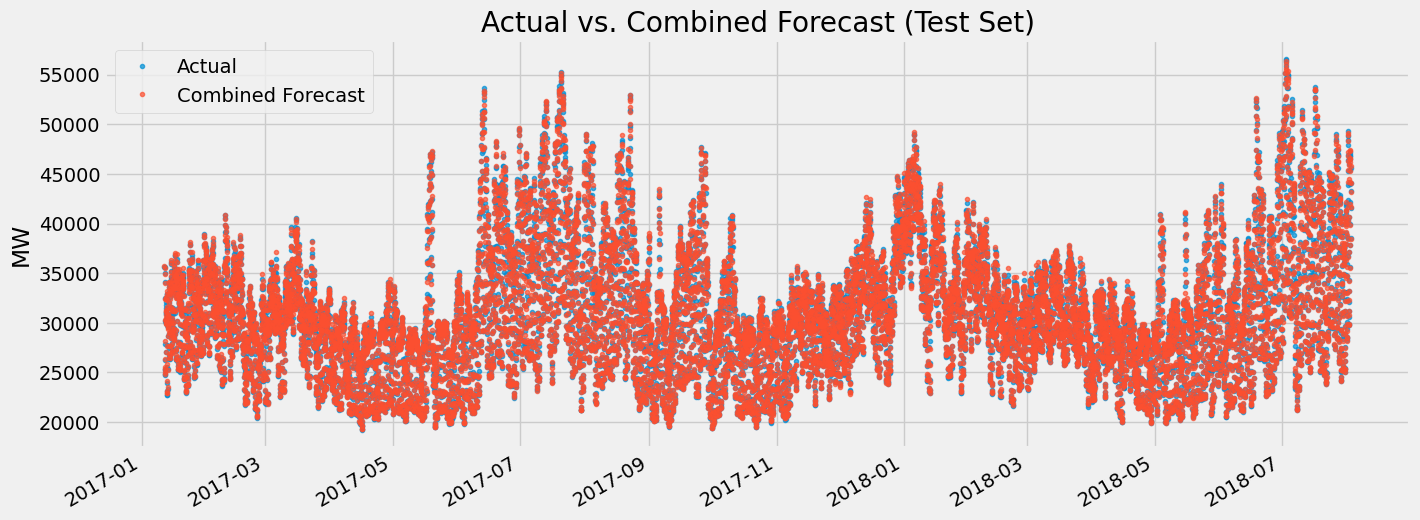

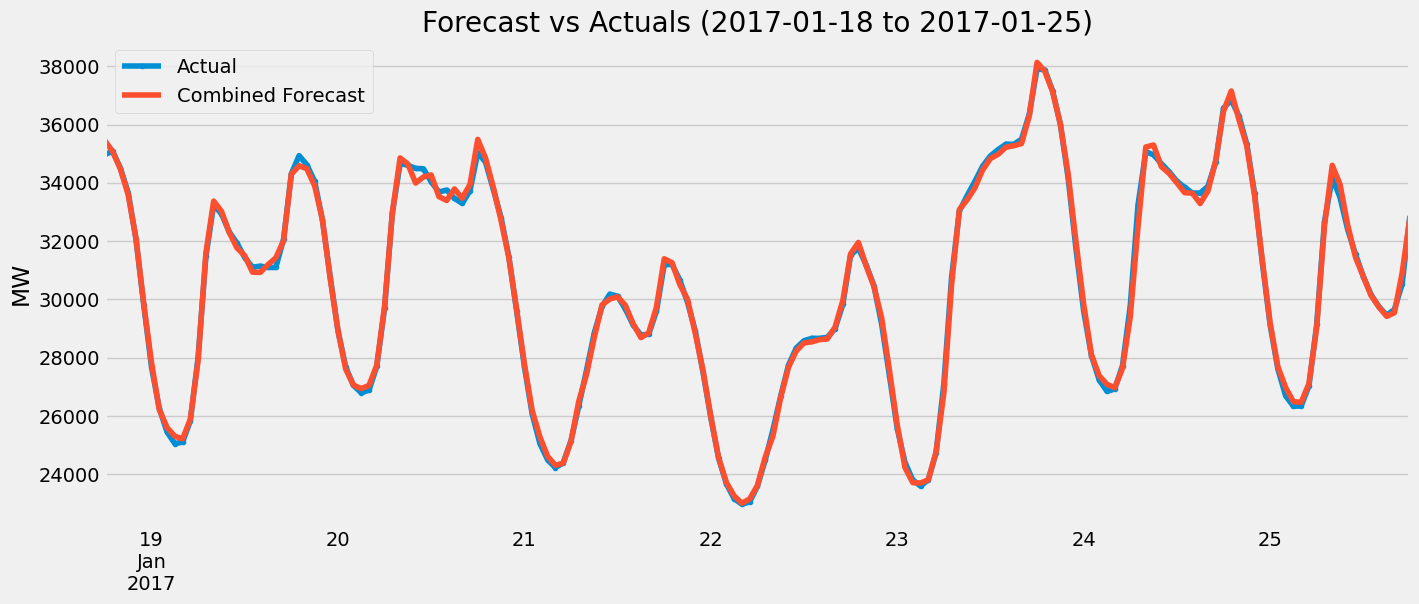

In [20]:
# Plot actual vs predicted for a period in the test set
fig, ax = plt.subplots(figsize=(15, 6))
test_df_aligned[TARGET].plot(ax=ax, label='Actual', style='.', alpha=0.7)
test_df_aligned['Combined_pred'].plot(ax=ax, label='Combined Forecast', style='.', alpha=0.7)
# test_df_aligned['ARIMA_pred'].plot(ax=ax, label='ARIMA Forecast', style='--', alpha=0.7)
ax.set_title('Actual vs. Combined Forecast (Test Set)')
ax.set_ylabel('MW')
ax.legend()
plt.show()

# Zoom in on a specific week
start_date = test_df_aligned.index.min() + pd.Timedelta(days=7)
end_date = start_date + pd.Timedelta(days=7)

fig, ax = plt.subplots(figsize=(15, 6))
test_df_aligned.loc[start_date:end_date, TARGET].plot(ax=ax, label='Actual', style='.-')
test_df_aligned.loc[start_date:end_date, 'Combined_pred'].plot(ax=ax, label='Combined Forecast', style='-')
ax.set_title(f'Forecast vs Actuals ({start_date.date()} to {end_date.date()})')
ax.set_ylabel('MW')
ax.legend()
plt.show()

## 11. Error Analysis: Worst/Best Predicted Days

In [21]:
# Calculate error and absolute error for each prediction in the aligned test set
test_df_aligned['error'] = test_df_aligned[TARGET] - test_df_aligned['Combined_pred']
test_df_aligned['abs_error'] = test_df_aligned['error'].abs()

# Group by date and calculate mean errors
error_by_day = test_df_aligned.groupby(test_df_aligned.index.date) \
    .agg(mean_Actual_MW=('PJME_MW', 'mean'),
         mean_Combined_Pred=('Combined_pred', 'mean'),
         mean_error=('error', 'mean'),
         mean_abs_error=('abs_error', 'mean'))

# Add weekday name for context
error_by_day['weekday'] = pd.to_datetime(error_by_day.index).strftime('%A')

print("--- Top 10 Days with Worst Mean Absolute Error ---")
worst_days = error_by_day.sort_values('mean_abs_error', ascending=False).head(10)
print(worst_days)

print("\n--- Top 10 Days with Best Mean Absolute Error ---")
best_days = error_by_day.sort_values('mean_abs_error', ascending=True).head(10)
print(best_days)

--- Top 10 Days with Worst Mean Absolute Error ---
            mean_Actual_MW  mean_Combined_Pred  mean_error  mean_abs_error  \
2017-08-21    36980.000000        36916.978406   63.021594      336.661646   
2017-12-29    39392.458333        39426.033642  -33.575309      335.369796   
2017-03-12    32130.565217        32079.349147   51.216070      326.600103   
2018-07-17    41080.875000        41143.005602  -62.130602      308.306764   
2018-01-04    41065.000000        40991.215466   73.784534      251.632104   
2018-07-05    42402.375000        42275.538832  126.836168      247.895752   
2018-07-06    39145.250000        39255.834296 -110.584296      243.849441   
2018-05-15    31481.666667        31441.947548   39.719119      237.694709   
2017-07-04    34663.791667        34717.853187  -54.061521      236.984532   
2017-12-31    39016.000000        38981.189091   34.810909      234.904570   

             weekday  
2017-08-21    Monday  
2017-12-29    Friday  
2017-03-12    Sunday 

### Worst Predicted Day Visualization

Plotting worst predicted day: 2017-08-21


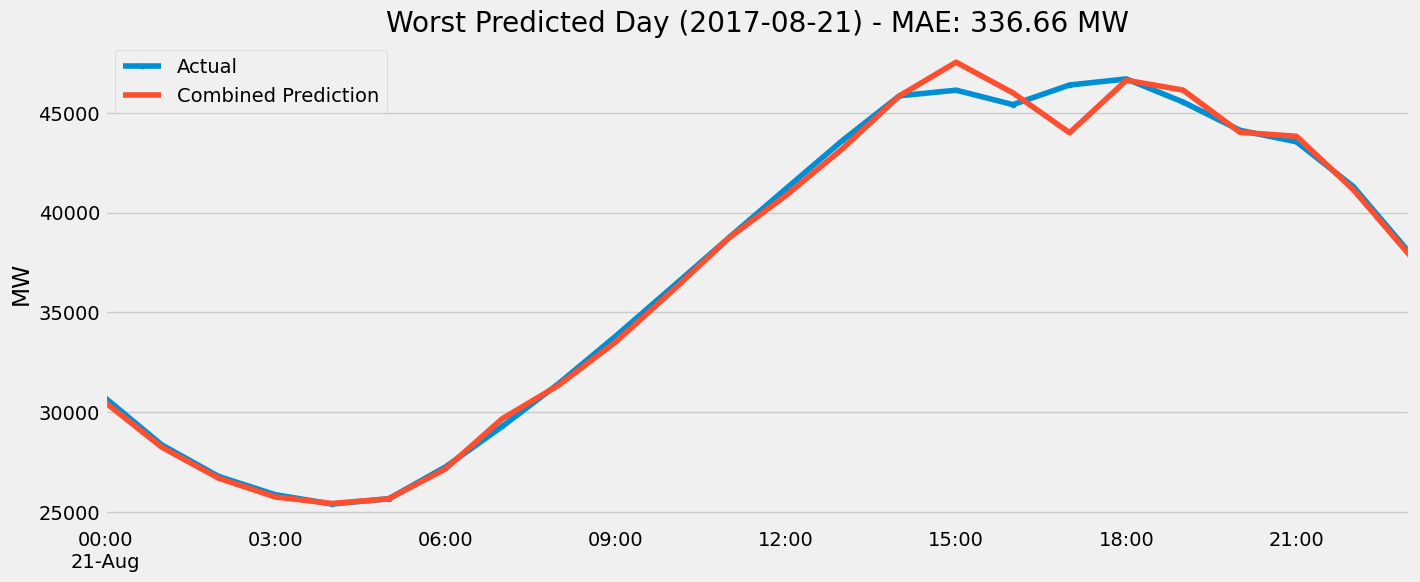

In [22]:
# Find the date with the highest mean absolute error
worst_day_date = error_by_day['mean_abs_error'].idxmax()
worst_day_str = worst_day_date.strftime('%Y-%m-%d')

print(f"Plotting worst predicted day: {worst_day_str}")

fig, ax = plt.subplots(figsize=(15, 6))
test_df_aligned.loc[worst_day_str][TARGET].plot(ax=ax, label='Actual', style='.-')
test_df_aligned.loc[worst_day_str]['Combined_pred'].plot(ax=ax, label='Combined Prediction', style='-')
ax.set_title(f'Worst Predicted Day ({worst_day_str}) - MAE: {error_by_day.loc[worst_day_date, "mean_abs_error"]:.2f} MW')
ax.set_ylabel('MW')
ax.legend()
plt.show()

### Best Predicted Day Visualization

Plotting best predicted day: 2017-10-22


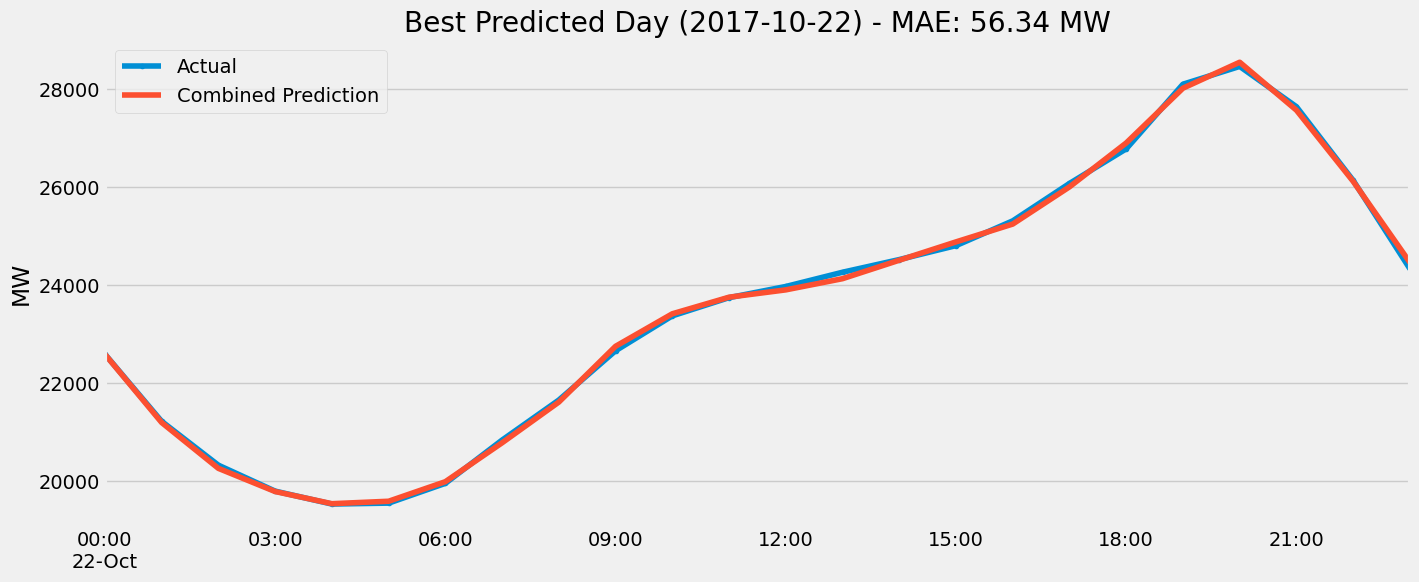

In [23]:
# Find the date with the lowest mean absolute error
best_day_date = error_by_day['mean_abs_error'].idxmin()
best_day_str = best_day_date.strftime('%Y-%m-%d')

print(f"Plotting best predicted day: {best_day_str}")

fig, ax = plt.subplots(figsize=(15, 6))
test_df_aligned.loc[best_day_str][TARGET].plot(ax=ax, label='Actual', style='.-')
test_df_aligned.loc[best_day_str]['Combined_pred'].plot(ax=ax, label='Combined Prediction', style='-')
ax.set_title(f'Best Predicted Day ({best_day_str}) - MAE: {error_by_day.loc[best_day_date, "mean_abs_error"]:.2f} MW')
ax.set_ylabel('MW')
ax.legend()
plt.show()